(survival_analysis)=
# Bayesian Survival Analysis

:::{post} Jun, 2022
:tags: survival analysis
:category: intermediate, how-to
:author: Austin Rochford
:::

[Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) studies the distribution of the time to an event.  Its applications span many fields across medicine, biology, engineering, and social science.  This tutorial shows how to fit and analyze a Bayesian survival model in Python using PyMC.

We illustrate these concepts by analyzing a [mastectomy data set](https://vincentarelbundock.github.io/Rdatasets/doc/HSAUR/mastectomy.html) from `R`'s [HSAUR](https://cran.r-project.org/web/packages/HSAUR/index.html) package.

In [1]:
import aesara
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm

%matplotlib inline
import aesara.tensor as at

from matplotlib import pyplot as plt

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
try:
    df = pd.read_csv("../data/mastectomy.csv")
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("mastectomy.csv"))

df.event = df.event.astype(np.int64)
df.metastasized = (df.metastasized == "yes").astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

In [4]:
df.head()

,time,event,metastasized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


In [5]:
n_patients

44

Each row represents observations from a woman diagnosed with breast cancer that underwent a mastectomy.  The column `time` represents the time (in months) post-surgery that the woman was observed.  The column `event` indicates whether or not the woman died during the observation period.  The column `metastasized` represents whether the cancer had [metastasized](https://en.wikipedia.org/wiki/Metastatic_breast_cancer) prior to surgery.

This tutorial analyzes the relationship between survival time post-mastectomy and whether or not the cancer had metastasized.

#### A crash course in survival analysis

First we introduce a (very little) bit of theory.  If the random variable $T$ is the time to the event we are studying, survival analysis is primarily concerned with the survival function

$$S(t) = P(T > t) = 1 - F(t),$$

where $F$ is the [CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of $T$.  It is mathematically convenient to express the survival function in terms of the [hazard rate](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function), $\lambda(t)$.  The hazard rate is the instantaneous probability that the event occurs at time $t$ given that it has not yet occurred.  That is,

$$\begin{align*}
\lambda(t)
    & = \lim_{\Delta t \to 0} \frac{P(t < T < t + \Delta t\ |\ T > t)}{\Delta t} \\
    & = \lim_{\Delta t \to 0} \frac{P(t < T < t + \Delta t)}{\Delta t \cdot P(T > t)} \\
    & = \frac{1}{S(t)} \cdot \lim_{\Delta t \to 0} \frac{S(t) - S(t + \Delta t)}{\Delta t}
      = -\frac{S'(t)}{S(t)}.
\end{align*}$$

Solving this differential equation for the survival function shows that

$$S(t) = \exp\left(-\int_0^s \lambda(s)\ ds\right).$$

This representation of the survival function shows that the cumulative hazard function

$$\Lambda(t) = \int_0^t \lambda(s)\ ds$$

is an important quantity in survival analysis, since we may concisely write $S(t) = \exp(-\Lambda(t)).$

An important, but subtle, point in survival analysis is [censoring](https://en.wikipedia.org/wiki/Survival_analysis#Censoring).  Even though the quantity we are interested in estimating is the time between surgery and death, we do not observe the death of every subject.  At the point in time that we perform our analysis, some of our subjects will thankfully still be alive. In the case of our mastectomy study, `df.event` is one if the subject's death was observed (the observation is not censored) and is zero if the death was not observed (the observation is censored).

In [6]:
df.event.mean()

0.5909090909090909

Just over 40% of our observations are censored.  We visualize the observed durations and indicate which observations are censored below.

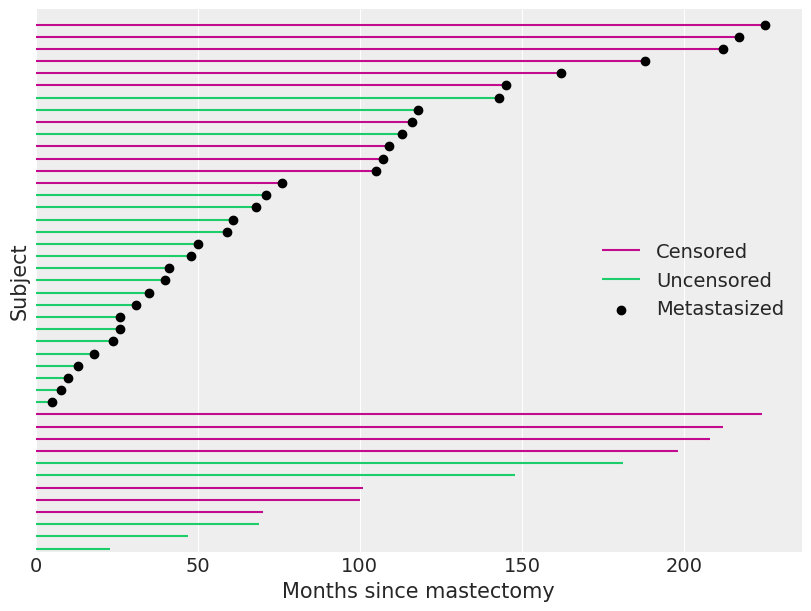

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hlines(
    patients[df.event.values == 0], 0, df[df.event.values == 0].time, color="C3", label="Censored"
)

ax.hlines(
    patients[df.event.values == 1], 0, df[df.event.values == 1].time, color="C7", label="Uncensored"
)

ax.scatter(
    df[df.metastasized.values == 1].time,
    patients[df.metastasized.values == 1],
    color="k",
    zorder=10,
    label="Metastasized",
)

ax.set_xlim(left=0)
ax.set_xlabel("Months since mastectomy")
ax.set_yticks([])
ax.set_ylabel("Subject")

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc="center right");

When an observation is censored (`df.event` is zero), `df.time` is not the subject's survival time.  All we can conclude from such a censored observation is that the subject's true survival time exceeds `df.time`.

This is enough basic survival analysis theory for the purposes of this tutorial; for a more extensive introduction, consult Aalen et al.^[Aalen, Odd, Ornulf Borgan, and Hakon Gjessing. Survival and event history analysis: a process point of view. Springer Science & Business Media, 2008.]

#### Bayesian proportional hazards model

The two most basic estimators in survival analysis are the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) of the survival function and the [Nelson-Aalen estimator](https://en.wikipedia.org/wiki/Nelson%E2%80%93Aalen_estimator) of the cumulative hazard function.  However, since we want to understand the impact of metastization on survival time, a risk regression model is more appropriate.  Perhaps the most commonly used risk regression model is [Cox's proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model).  In this model, if we have covariates $\mathbf{x}$ and regression coefficients $\beta$, the hazard rate is modeled as

$$\lambda(t) = \lambda_0(t) \exp(\mathbf{x} \beta).$$

Here $\lambda_0(t)$ is the baseline hazard, which is independent of the covariates $\mathbf{x}$.  In this example, the covariates are the one-dimensional vector `df.metastasized`.

Unlike in many regression situations, $\mathbf{x}$ should not include a constant term corresponding to an intercept.  If $\mathbf{x}$ includes a constant term corresponding to an intercept, the model becomes [unidentifiable](https://en.wikipedia.org/wiki/Identifiability).  To illustrate this unidentifiability, suppose that

$$\lambda(t) = \lambda_0(t) \exp(\beta_0 + \mathbf{x} \beta) = \lambda_0(t) \exp(\beta_0) \exp(\mathbf{x} \beta).$$

If $\tilde{\beta}_0 = \beta_0 + \delta$ and $\tilde{\lambda}_0(t) = \lambda_0(t) \exp(-\delta)$, then $\lambda(t) = \tilde{\lambda}_0(t) \exp(\tilde{\beta}_0 + \mathbf{x} \beta)$ as well, making the model with $\beta_0$ unidentifiable.

In order to perform Bayesian inference with the Cox model, we must specify priors on $\beta$ and $\lambda_0(t)$.  We place a normal prior on $\beta$, $\beta \sim N(\mu_{\beta}, \sigma_{\beta}^2),$ where $\mu_{\beta} \sim N(0, 10^2)$ and $\sigma_{\beta} \sim U(0, 10)$.

A suitable prior on $\lambda_0(t)$ is less obvious.  We choose a semiparametric prior, where $\lambda_0(t)$ is a piecewise constant function.  This prior requires us to partition the time range in question into intervals with endpoints $0 \leq s_1 < s_2 < \cdots < s_N$.  With this partition, $\lambda_0 (t) = \lambda_j$ if $s_j \leq t < s_{j + 1}$.  With $\lambda_0(t)$ constrained to have this form, all we need to do is choose priors for the $N - 1$ values $\lambda_j$.  We use independent vague priors $\lambda_j \sim \operatorname{Gamma}(10^{-2}, 10^{-2}).$  For our mastectomy example, we make each interval three months long.

In [8]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

We see how deaths and censored observations are distributed in these intervals.

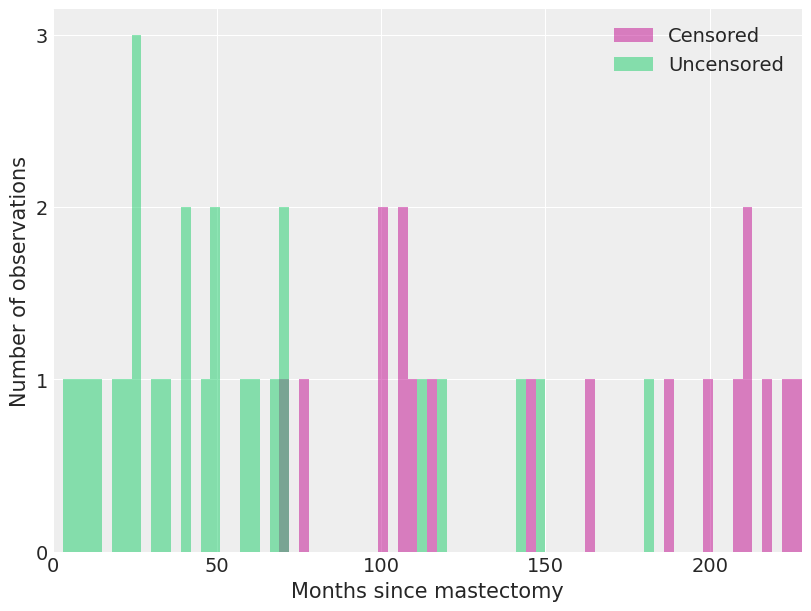

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(
    df[df.event == 0].time.values,
    bins=interval_bounds,
    lw=0,
    color="C3",
    alpha=0.5,
    label="Censored",
)

ax.hist(
    df[df.event == 1].time.values,
    bins=interval_bounds,
    lw=0,
    color="C7",
    alpha=0.5,
    label="Uncensored",
)

ax.set_xlim(0, interval_bounds[-1])
ax.set_xlabel("Months since mastectomy")

ax.set_yticks([0, 1, 2, 3])
ax.set_ylabel("Number of observations")

ax.legend();

With the prior distributions on $\beta$ and $\lambda_0(t)$ chosen, we now show how the model may be fit using MCMC simulation with `pymc`.  The key observation is that the piecewise-constant proportional hazard model is [closely related](http://data.princeton.edu/wws509/notes/c7s4.html) to a Poisson regression model.   (The models are not identical, but their likelihoods differ by a factor that depends only on the observed data and not the parameters $\beta$ and $\lambda_j$.  For details, see Germán Rodríguez's WWS 509 [course notes](http://data.princeton.edu/wws509/notes/c7s4.html).)

We define indicator variables based on whether the $i$-th subject died in the $j$-th interval,

$$d_{i, j} = \begin{cases}
    1 & \textrm{if subject } i \textrm{ died in interval } j \\
    0 & \textrm{otherwise}
\end{cases}.$$

In [10]:
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)

death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.event

We also define $t_{i, j}$ to be the amount of time the $i$-th subject was at risk in the $j$-th interval.

In [11]:
exposure = np.greater_equal.outer(df.time.to_numpy(), interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

Finally, denote the risk incurred by the $i$-th subject in the $j$-th interval as $\lambda_{i, j} = \lambda_j \exp(\mathbf{x}_i \beta)$.

We may approximate $d_{i, j}$ with a Poisson random variable with mean $t_{i, j}\ \lambda_{i, j}$.  This approximation leads to the following `pymc` model.

In [12]:
coords = {"intervals": intervals}

with pm.Model(coords=coords) as model:

    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")

    beta = pm.Normal("beta", 0, sigma=1000)

    lambda_ = pm.Deterministic(
        "lambda_", at.outer(pm.math.exp(beta * df.metastasized.values), lambda0)
    )
    mu = pm.Deterministic("mu", exposure * lambda_)

    obs = pm.Poisson("obs", mu, observed=death)

We now sample from the model.

In [13]:
n_samples = 1000
n_tune = 1000

In [14]:
with model:
    idata = pm.sample(
        n_samples,
        tune=n_tune,
        target_accept=0.99,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 241 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


We see that the hazard rate for subjects whose cancer has metastasized is about one and a half times the rate of those whose cancer has not metastasized.

In [15]:
np.exp(idata.posterior["beta"]).mean()

<xarray.DataArray 'beta' ()>
array(2.52656768)

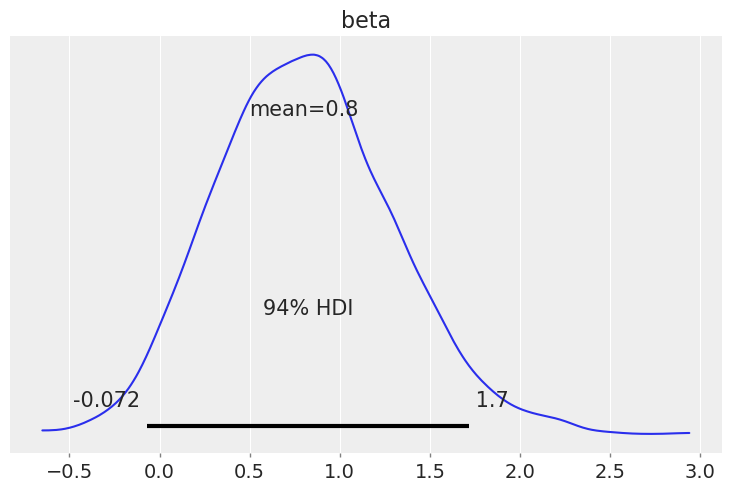

In [16]:
az.plot_posterior(idata, var_names=["beta"]);

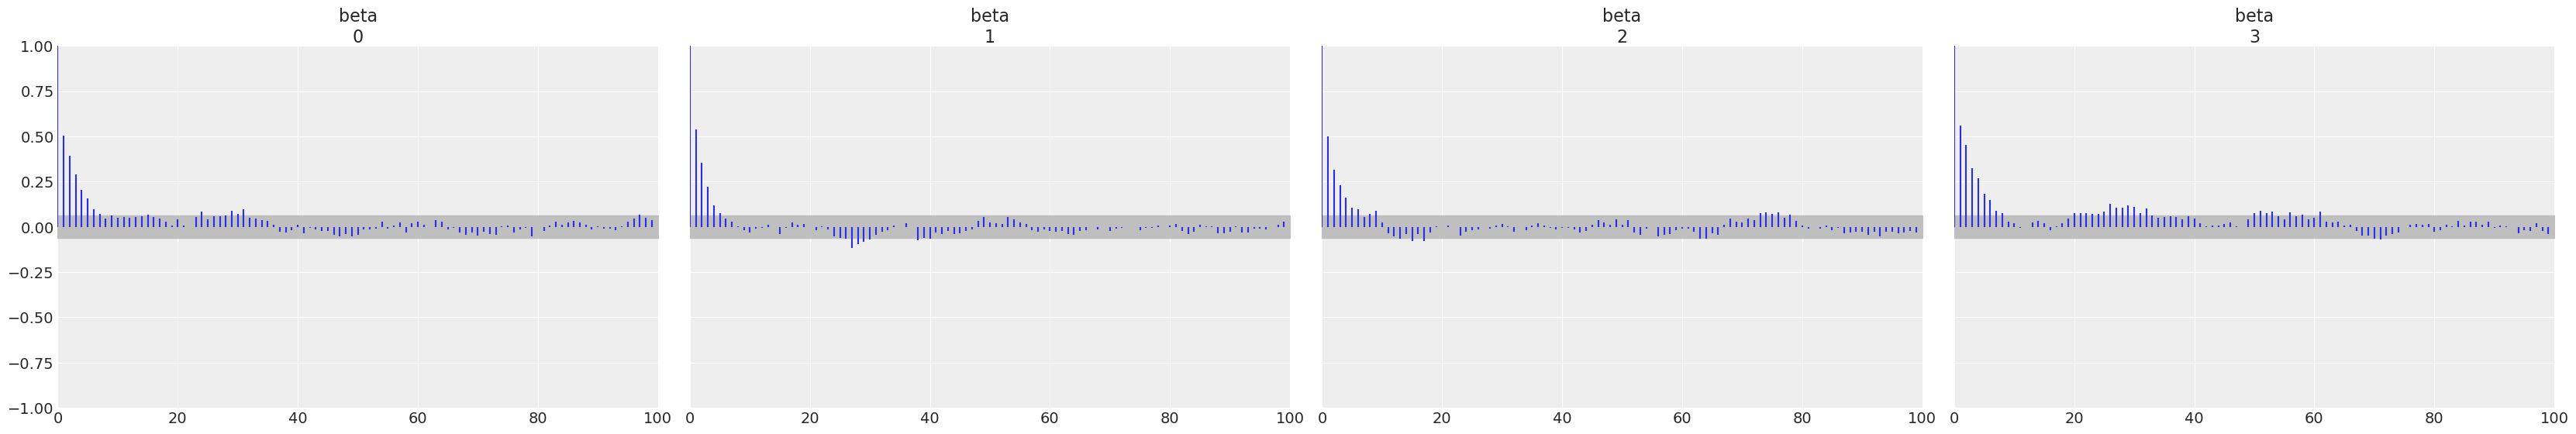

In [17]:
az.plot_autocorr(idata, var_names=["beta"]);

We now examine the effect of metastization on both the cumulative hazard and on the survival function.

In [18]:
base_hazard = idata.posterior["lambda0"]
met_hazard = idata.posterior["lambda0"] * np.exp(idata.posterior["beta"])

In [19]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)


def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def get_mean(trace):
    return trace.mean(("chain", "draw"))

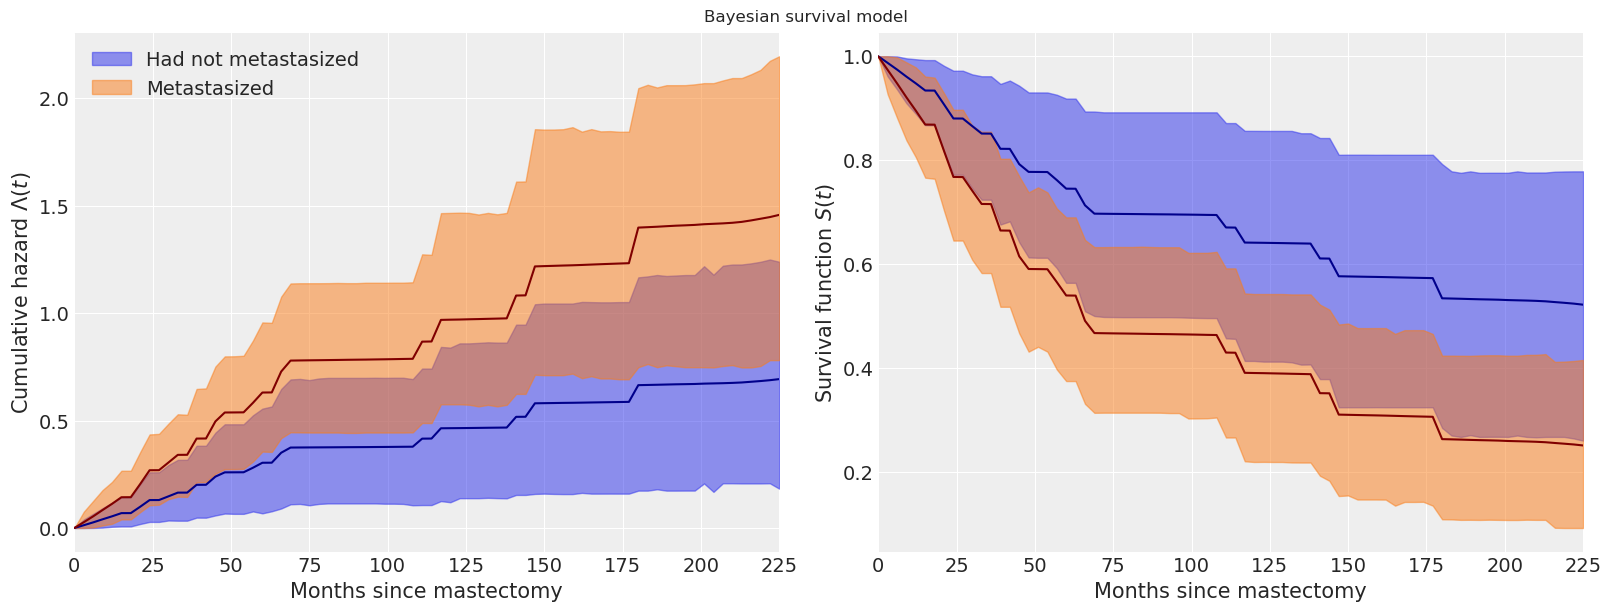

In [20]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(base_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C0",
    fill_kwargs={"label": "Had not metastasized"},
)
az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Metastasized"},
)

hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(base_hazard)), color="darkblue")
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(met_hazard)), color="maroon")

hazard_ax.set_xlim(0, df.time.max())
hazard_ax.set_xlabel("Months since mastectomy")
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(interval_bounds[:-1], survival(base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(interval_bounds[:-1], get_mean(survival(base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(met_hazard)), color="maroon")

surv_ax.set_xlim(0, df.time.max())
surv_ax.set_xlabel("Months since mastectomy")
surv_ax.set_ylabel("Survival function $S(t)$")

fig.suptitle("Bayesian survival model");

We see that the cumulative hazard for metastasized subjects increases more rapidly initially (through about seventy months), after which it increases roughly in parallel with the baseline cumulative hazard.

These plots also show the pointwise 95% high posterior density interval for each function.  One of the distinct advantages of the Bayesian model fit with `pymc` is the inherent quantification of uncertainty in our estimates.

##### Time varying effects

Another of the advantages of the model we have built is its flexibility.  From the plots above, we may reasonable believe that the additional hazard due to metastization varies over time; it seems plausible that cancer that has metastasized increases the hazard rate immediately after the mastectomy, but that the risk due to metastization decreases over time.  We can accommodate this mechanism in our model by allowing the regression coefficients to vary over time.  In the time-varying coefficient model, if $s_j \leq t < s_{j + 1}$, we let $\lambda(t) = \lambda_j \exp(\mathbf{x} \beta_j).$  The sequence of regression coefficients $\beta_1, \beta_2, \ldots, \beta_{N - 1}$ form a normal random walk with $\beta_1 \sim N(0, 1)$, $\beta_j\ |\ \beta_{j - 1} \sim N(\beta_{j - 1}, 1)$.

We implement this model in `pymc` as follows.

In [21]:
coords = {"intervals": intervals}

with pm.Model(coords=coords) as time_varying_model:

    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")
    beta = pm.GaussianRandomWalk("beta", sigma=1.0, dims="intervals")

    lambda_ = pm.Deterministic(
        "h", lambda0 * pm.math.exp(at.outer(pm.math.constant(df.metastasized), beta))
    )
    mu = pm.Deterministic("mu", exposure * lambda_)

    obs = pm.Poisson("obs", mu, observed=death)

/Users/fernandoi/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pymc/distributions/timeseries.py:274: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


We proceed to sample from this model.

In [22]:
with time_varying_model:
    time_varying_idata = pm.sample(
        n_samples,
        tune=n_tune,
        target_accept=0.99,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 405 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


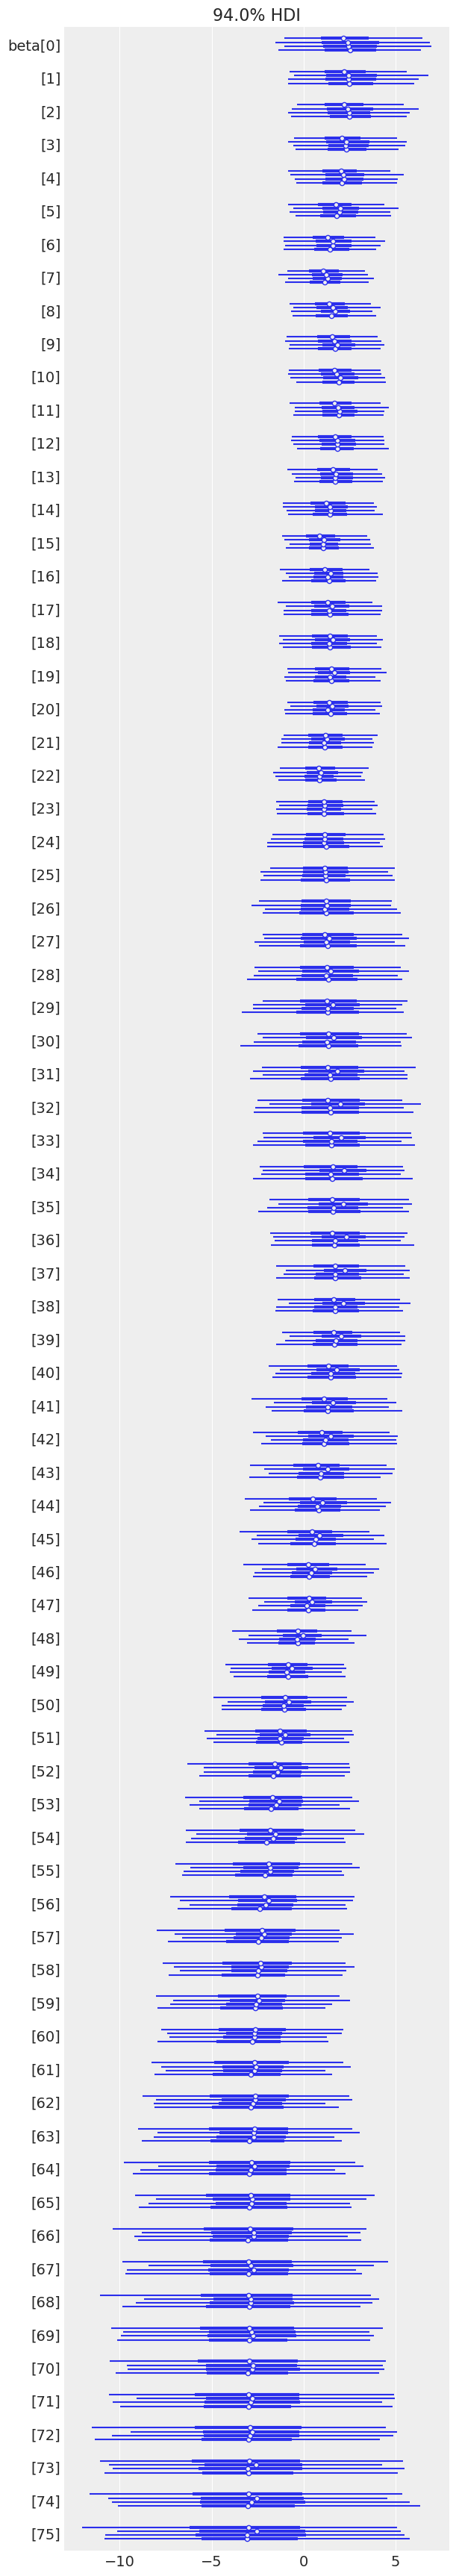

In [23]:
az.plot_forest(time_varying_idata, var_names=["beta"]);

We see from the plot of $\beta_j$ over time below that initially $\beta_j > 0$, indicating an elevated hazard rate due to metastization, but that this risk declines as $\beta_j < 0$ eventually.

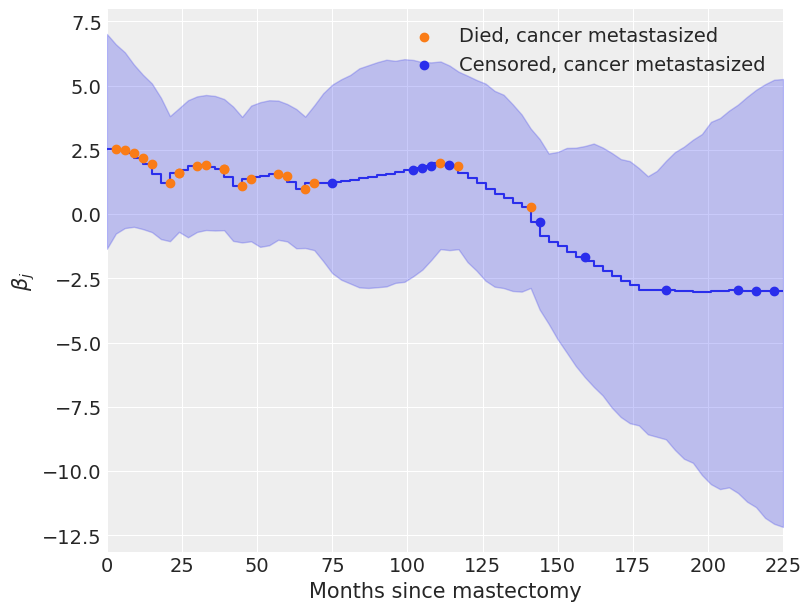

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

beta_eti = time_varying_idata.posterior["beta"].quantile((0.025, 0.975), dim=("chain", "draw"))
beta_eti_low = beta_eti.sel(quantile=0.025)
beta_eti_high = beta_eti.sel(quantile=0.975)

ax.fill_between(interval_bounds[:-1], beta_eti_low, beta_eti_high, color="C0", alpha=0.25)

beta_hat = time_varying_idata.posterior["beta"].mean(("chain", "draw"))

ax.step(interval_bounds[:-1], beta_hat, color="C0")

ax.scatter(
    interval_bounds[last_period[(df.event.values == 1) & (df.metastasized == 1)]],
    beta_hat.isel(intervals=last_period[(df.event.values == 1) & (df.metastasized == 1)]),
    color="C1",
    zorder=10,
    label="Died, cancer metastasized",
)

ax.scatter(
    interval_bounds[last_period[(df.event.values == 0) & (df.metastasized == 1)]],
    beta_hat.isel(intervals=last_period[(df.event.values == 0) & (df.metastasized == 1)]),
    color="C0",
    zorder=10,
    label="Censored, cancer metastasized",
)

ax.set_xlim(0, df.time.max())
ax.set_xlabel("Months since mastectomy")
ax.set_ylabel(r"$\beta_j$")
ax.legend();

The coefficients $\beta_j$ begin declining rapidly around one hundred months post-mastectomy, which seems reasonable, given that only three of twelve subjects whose cancer had metastasized lived past this point died during the study.

The change in our estimate of the cumulative hazard and survival functions due to time-varying effects is also quite apparent in the following plots.

In [25]:
tv_base_hazard = time_varying_idata.posterior["lambda0"]
tv_met_hazard = time_varying_idata.posterior["lambda0"] * np.exp(
    time_varying_idata.posterior["beta"]
)

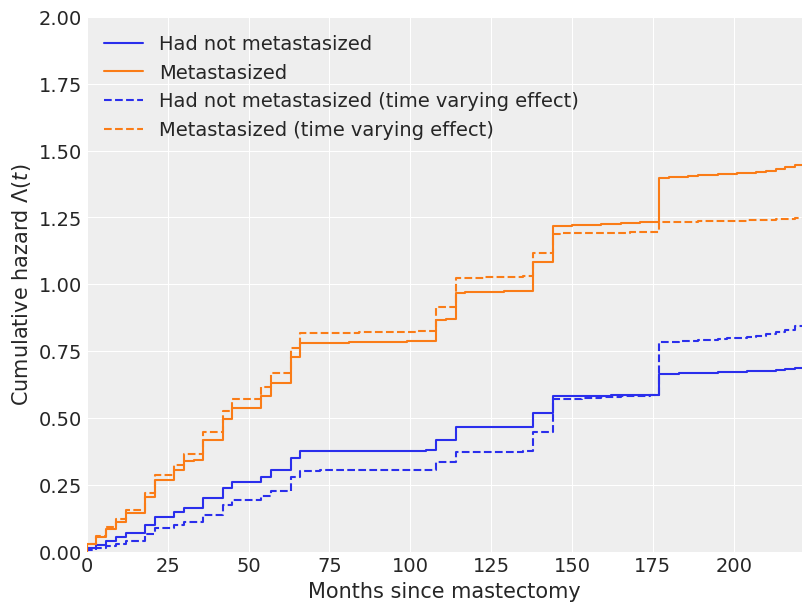

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.step(
    interval_bounds[:-1],
    cum_hazard(base_hazard.mean(("chain", "draw"))),
    color="C0",
    label="Had not metastasized",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(met_hazard.mean(("chain", "draw"))),
    color="C1",
    label="Metastasized",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(tv_base_hazard.mean(("chain", "draw"))),
    color="C0",
    linestyle="--",
    label="Had not metastasized (time varying effect)",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(tv_met_hazard.mean(dim=("chain", "draw"))),
    color="C1",
    linestyle="--",
    label="Metastasized (time varying effect)",
)

ax.set_xlim(0, df.time.max() - 4)
ax.set_xlabel("Months since mastectomy")
ax.set_ylim(0, 2)
ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
ax.legend(loc=2);

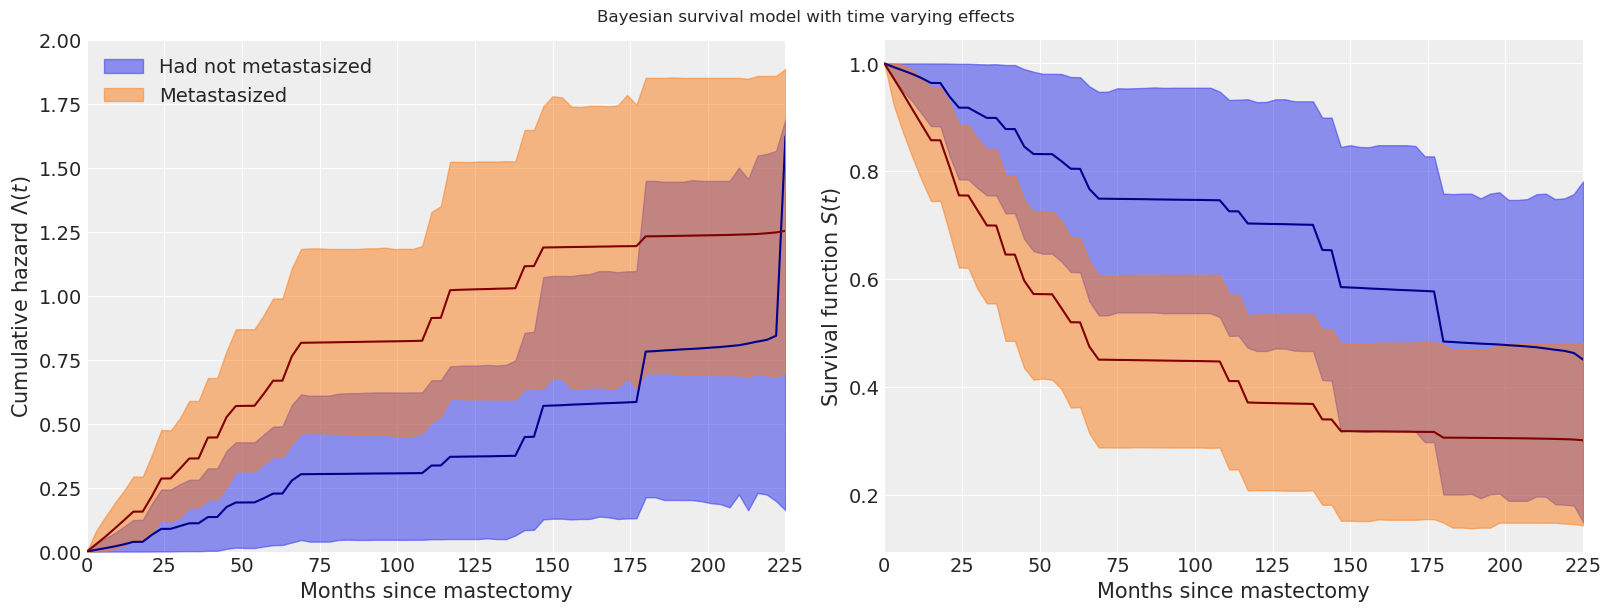

In [27]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(tv_base_hazard),
    ax=hazard_ax,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "Had not metastasized"},
)

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(tv_met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Metastasized"},
)

hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(tv_base_hazard)), color="darkblue")
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(tv_met_hazard)), color="maroon")

hazard_ax.set_xlim(0, df.time.max())
hazard_ax.set_xlabel("Months since mastectomy")
hazard_ax.set_ylim(0, 2)
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(interval_bounds[:-1], survival(tv_base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(tv_met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(interval_bounds[:-1], get_mean(survival(tv_base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(tv_met_hazard)), color="maroon")

surv_ax.set_xlim(0, df.time.max())
surv_ax.set_xlabel("Months since mastectomy")
surv_ax.set_ylabel("Survival function $S(t)$")
fig.suptitle("Bayesian survival model with time varying effects");

We have really only scratched the surface of both survival analysis and the Bayesian approach to survival analysis.  More information on Bayesian survival analysis is available in Ibrahim et al. (2005).  (For example, we may want to account for individual frailty in either or original or time-varying models.)

Notebook adapted from a blog post that first appeared [here](http://austinrochford.com/posts/2015-10-05-bayes-survival.html).

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aeppl

Last updated: Sun Jun 05 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

aeppl: 0.0.31

aesara    : 2.6.6
pymc      : 4.0.0
pandas    : 1.4.2
matplotlib: 3.5.1
numpy     : 1.22.4
arviz     : 0.12.1

Watermark: 2.3.1

